In [1]:
import tensorflow as tf

keras = tf.keras
import pandas as pd, numpy as np
import os, unidecode, glob
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')

from pylab import rcParams
rcParams['figure.figsize'] = (15, 8)

import math
from sklearn.metrics import mean_squared_error

In [2]:
if tf.test.gpu_device_name(): 
    print('Default GPU Device:{}'.format(tf.test.gpu_device_name()))
else:
   print("Please install GPU version of TF")

Default GPU Device:/device:GPU:0


In [3]:
check_df = pd.concat([pd.read_parquet(f) for f in glob.glob(os.getcwd()+'/filtered_data/checkin/*.parquet')], ignore_index=True)

check_df['date'] = check_df.date.apply(lambda x: x.split(','))
check_df = check_df.explode('date').reset_index().drop('index',axis=1)
check_df['date'] = pd.to_datetime(check_df.date)

In [4]:
bus_df = pd.concat([pd.read_parquet(f) for f in glob.glob(os.getcwd()+'/filtered_data/business/*.parquet')], ignore_index=True)

bus_df['city'] = bus_df.city.apply(lambda x: unidecode.unidecode(x))
bus_df['state'] = np.select(
    [
        bus_df['city'].isin(['Toronto', 'Richmond Hill', 'Scarborough', 'Markham', 'Mississauga', 'Brampton', 'Vaughan', 'North York']),
        bus_df['city'].isin(['Calgary']),
        bus_df['city'].isin(['Montreal']),
    ],
    [
        'ON',
        'AB',
        'QC'
    ]
)

In [5]:
df = bus_df[['business_id','city']].merge(check_df,on=['business_id'],how='inner')
df['city'] = df.city.astype('category')
df = df.assign(date=df.date.dt.round('H'))
df.head()

,business_id,city,date
0,EosRKXIGeSWFYWwpkbhNnA,Toronto,2012-06-12 19:00:00
1,EosRKXIGeSWFYWwpkbhNnA,Toronto,2013-02-11 15:00:00
2,EosRKXIGeSWFYWwpkbhNnA,Toronto,2013-02-22 18:00:00
3,EosRKXIGeSWFYWwpkbhNnA,Toronto,2013-03-05 21:00:00
4,EosRKXIGeSWFYWwpkbhNnA,Toronto,2013-03-06 17:00:00


In [6]:
pivot_df = df.pivot_table(index='date',values='business_id',columns='city',aggfunc='count', fill_value=0)
pivot_df.index = pd.DatetimeIndex(pivot_df.index)
pivot_df

city,Brampton,Calgary,Markham,Mississauga,Montreal,North York,Richmond Hill,Scarborough,Toronto,Vaughan
date,,,,,,,,,,
2010-01-16 02:00:00,0,1,0,0,0,0,0,0,0,0
2010-01-16 05:00:00,0,0,0,0,0,0,0,0,1,0
2010-01-16 10:00:00,0,0,0,0,0,0,0,0,2,0
2010-01-16 13:00:00,0,0,0,0,0,0,0,0,1,0
2010-01-16 15:00:00,0,1,0,0,0,0,0,0,2,0
...,...,...,...,...,...,...,...,...,...,...
2019-12-13 13:00:00,0,0,0,0,0,1,1,0,4,0
2019-12-13 14:00:00,0,0,0,0,0,0,1,0,4,0
2019-12-13 15:00:00,0,0,3,1,2,0,0,0,5,0


In [7]:
daily_tor = pivot_df.loc[:,'Toronto'].resample('D').sum().reset_index().rename(columns={'date':'ds','Toronto':'y'}).set_index('ds')

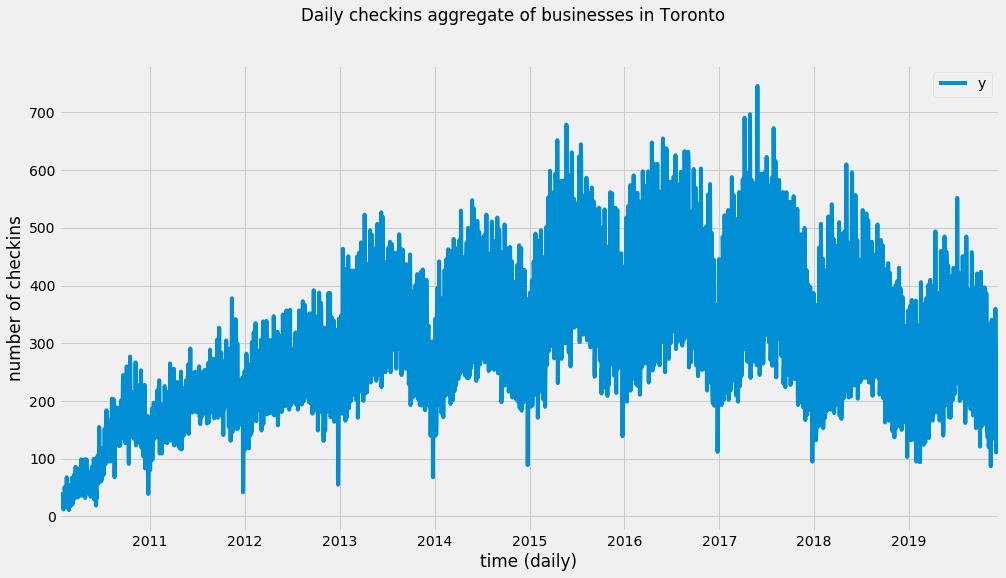

In [8]:
fig, ax = plt.subplots()
daily_tor.plot(ax=ax)
fig.suptitle('Daily checkins aggregate of businesses in Toronto')
ax.set(xlabel='time (daily)',ylabel=('number of checkins'))
plt.legend()
plt.show()

## Forecasting

In [9]:
def train_test_split(ts_df):
    test_split = '2019-01-01'
    train = ts_df.loc[ts_df.index < test_split].copy()
    test = ts_df.loc[(ts_df.index >= test_split)].copy()
    print(train.shape)
    print(test.shape)
    return (train,test)

d_train, d_test = train_test_split(daily_tor.loc[daily_tor.index > '2012-12-31'])
val_size = d_test.shape[0]
error_vals = list()

(2191, 1)
(347, 1)


In [10]:
def window_dataset(series, window_size, batch_size=32,
                   shuffle_buffer=1000):
    dataset = tf.data.Dataset.from_tensor_slices(series)
    dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)
    dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))
    dataset = dataset.shuffle(shuffle_buffer)
    dataset = dataset.map(lambda window: (window[:-1], window[-1]))
    dataset = dataset.batch(batch_size).prefetch(1)
    return dataset

In [11]:
def model_forecast(model, series, window_size):
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size))
    ds = ds.batch(32).prefetch(1)
    forecast = model.predict(ds)
    return forecast

In [12]:
ts_model_path = 'saved_models\\time_series'
if not os.path.exists(ts_model_path):
    os.makedirs(ts_model_path)

### Simple RNN

In [13]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

window_size = 30
train_set = window_dataset(d_train[:-1*val_size].y, window_size, batch_size=128)
valid_set = window_dataset(d_train[-1*val_size:].y, window_size, batch_size=128)

model = keras.models.Sequential([
  keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1),
                      input_shape=[None]),
  keras.layers.SimpleRNN(100, return_sequences=True),
  keras.layers.SimpleRNN(100),
  keras.layers.Dense(1),
  keras.layers.Lambda(lambda x: x * 200.0)
])
optimizer = keras.optimizers.SGD(lr=1.5e-6, momentum=0.9)
model.compile(loss=keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
early_stopping = keras.callbacks.EarlyStopping(patience=50)
model_checkpoint = keras.callbacks.ModelCheckpoint(
    os.path.join(ts_model_path,"rnn_checkpoint"), save_best_only=True)
model.fit(train_set, epochs=500,
          validation_data=valid_set,
          callbacks=[early_stopping, model_checkpoint])

Epoch 1/500
     15/Unknown - 3s 190ms/step - loss: 175.2176 - mae: 178.7224WARNING:tensorflow:From I:\Installed\anaconda3\lib\site-packages\tensorflow_core\python\ops\resource_variable_ops.py:1786: calling BaseResourceVariable.__init__ (from tensorflow.python.ops.resource_variable_ops) with constraint is deprecated and will be removed in a future version.
Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: saved_models\time_series\rnn_checkpoint\assets
15/15 [==============================] - 10s 674ms/step - loss: 175.4055 - mae: 178.7224 - val_loss: 144.1957 - val_mae: 144.5030
Epoch 2/500
15/15 [==============================] - 8s 501ms/step - loss: 93.7905 - mae: 96.2326 - val_loss: 85.1735 - val_mae: 85.9753
Epoch 3/500
15/15 [==============================] - 1s 57ms/step - loss: 84.0425 - mae: 85.1413 - val_loss: 90.7045 - val_mae: 92.2486
Epoch 4/500
15/15 [==============================] - 1s 60ms/step - loss: 8

In [14]:
rnn_model = keras.models.load_model(os.path.join(ts_model_path,"rnn_checkpoint"))

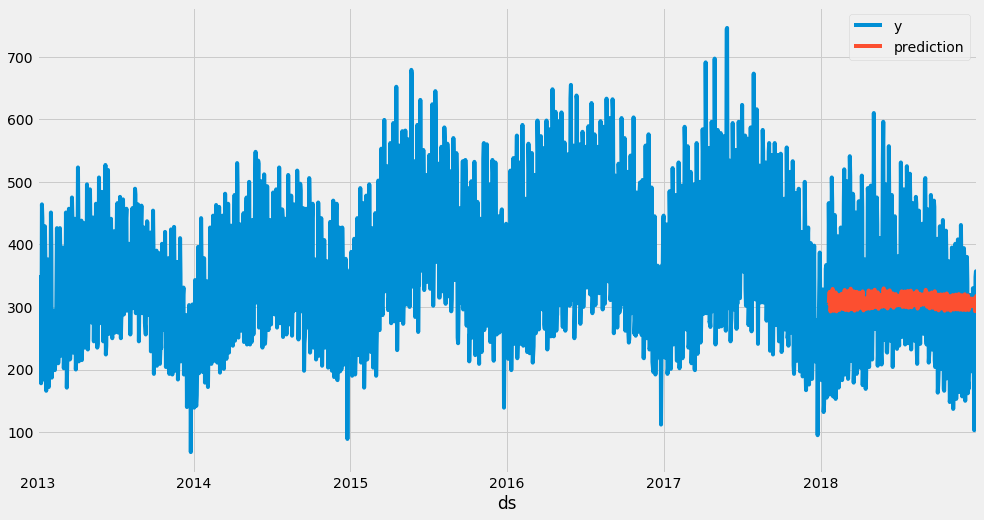

In [15]:
rnn_predict = model_forecast(rnn_model, d_train[-val_size-window_size:-1].y, window_size)[:, 0]
pred = pd.DataFrame(rnn_predict, \
            index=d_train[-val_size:].index,
            columns=['prediction'])

fig, ax = plt.subplots()
d_train.plot(label='observed',ax=ax)
pred.plot(ax=ax)
plt.legend()
plt.show()

In [16]:
rmse_train = math.sqrt(mean_squared_error(d_train[-val_size:], pred.prediction))
print("The root mean squared error is {}.".format(rmse_train))

The root mean squared error is 101.60093932094578.


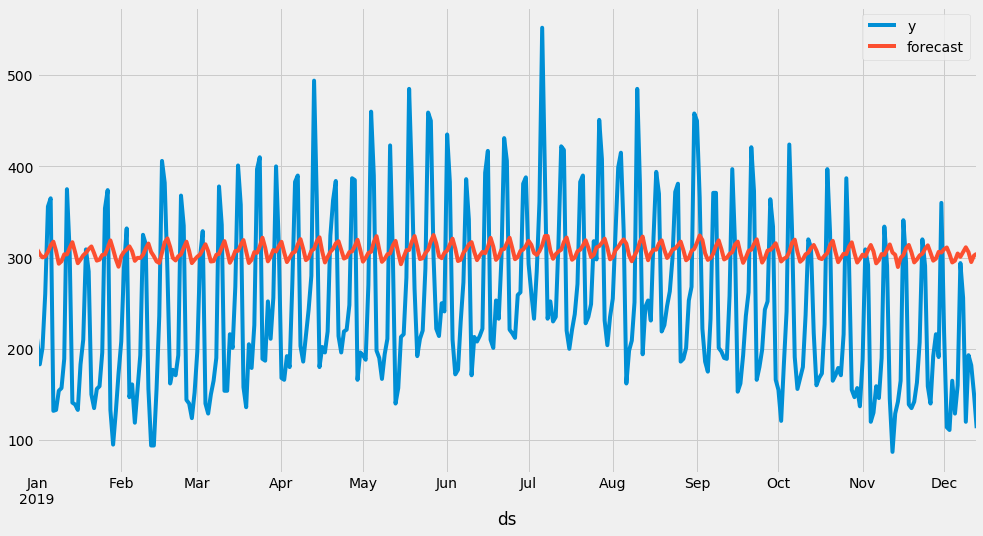

In [17]:
rnn_forecast = model_forecast(rnn_model, pd.concat([d_train[-window_size:],d_test[:-1]]).y, window_size)[:, 0]
fcast = pd.DataFrame(rnn_forecast, \
            index=d_test.index,
            columns=['forecast'])

fig, ax = plt.subplots()
d_test.plot(ax=ax)
fcast.plot(ax=ax)
plt.legend()
plt.show()

In [18]:
rmse_test = math.sqrt(mean_squared_error(d_test, fcast))
print("The root mean squared error is {}.".format(rmse_test))

The root mean squared error is 109.12524359222675.


In [19]:
mape = np.mean(np.abs(d_test.y.values - fcast.forecast.values) / d_test.y.values) * 100
print("The mean average percentage error is {}.".format(mape))

The mean average percentage error is 51.14567817327122.


### Sequence to sequence forecasting

In [20]:
def seq2seq_window_dataset(series, window_size, batch_size=32,
                           shuffle_buffer=1000):
    series = tf.expand_dims(series, axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    ds = ds.shuffle(shuffle_buffer)
    ds = ds.map(lambda w: (w[:-1], w[1:]))
    return ds.batch(batch_size).prefetch(1)

In [21]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

window_size = 8
train_set = seq2seq_window_dataset(d_train[:-1*val_size].y, window_size,
                                   batch_size=128)
valid_set = seq2seq_window_dataset(d_train[-1*val_size:].y, window_size,
                                   batch_size=128)

model = keras.models.Sequential([
  keras.layers.SimpleRNN(100, return_sequences=True,
                         input_shape=[None, 1]),
  keras.layers.SimpleRNN(100, return_sequences=True),
  keras.layers.Dense(1),
  keras.layers.Lambda(lambda x: x * 200.0)
])
optimizer = keras.optimizers.SGD(lr=1e-6, momentum=0.9)
model.compile(loss=keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
early_stopping = keras.callbacks.EarlyStopping(patience=50)
model_checkpoint = keras.callbacks.ModelCheckpoint(
    os.path.join(ts_model_path,"s2s_checkpoint"), save_best_only=True)
model.fit(train_set, epochs=500,
          validation_data=valid_set,
          callbacks=[early_stopping,model_checkpoint])

Epoch 1/500
     15/Unknown - 3s 172ms/step - loss: 196.0745 - mae: 199.3378INFO:tensorflow:Assets written to: saved_models\time_series\s2s_checkpoint\assets
15/15 [==============================] - 10s 641ms/step - loss: 196.2472 - mae: 199.3378 - val_loss: 158.6075 - val_mae: 159.1730
Epoch 2/500
15/15 [==============================] - 7s 444ms/step - loss: 108.8976 - mae: 110.1321 - val_loss: 85.2451 - val_mae: 85.8944
Epoch 3/500
15/15 [==============================] - 0s 32ms/step - loss: 90.2861 - mae: 90.7688 - val_loss: 97.1243 - val_mae: 97.6280
Epoch 4/500
15/15 [==============================] - 0s 32ms/step - loss: 85.0702 - mae: 85.6795 - val_loss: 85.7858 - val_mae: 86.0552
Epoch 5/500
15/15 [==============================] - 0s 30ms/step - loss: 83.3555 - mae: 83.8555 - val_loss: 87.8764 - val_mae: 88.5798
Epoch 6/500
15/15 [==============================] - 0s 30ms/step - loss: 82.9956 - mae: 83.4990 - val_loss: 87.2504 - val_mae: 87.5887
Epoch 7/500
15/15 [==========

In [22]:
s2s_model = keras.models.load_model(os.path.join(ts_model_path,"s2s_checkpoint"))

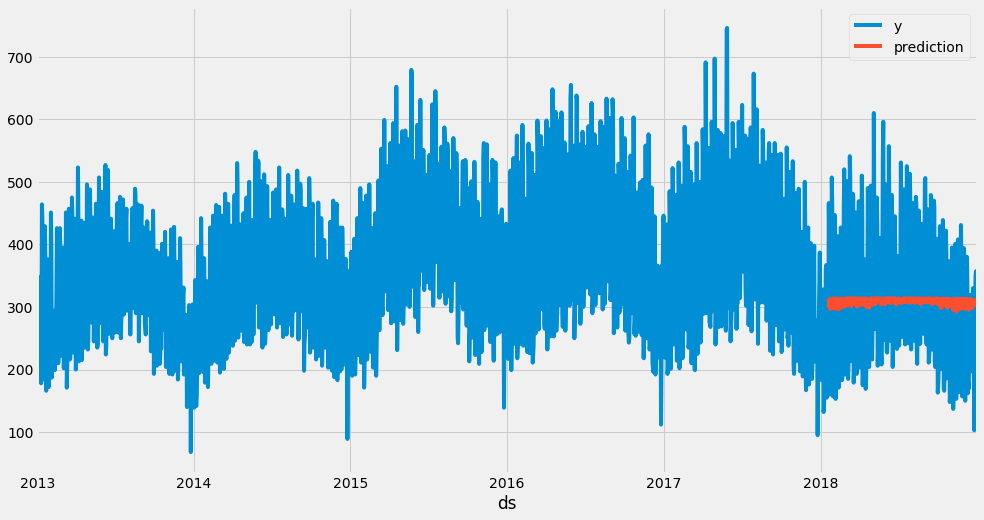

In [23]:
s2s_predict = model_forecast(s2s_model, d_train.y.values[-val_size-window_size:-1][..., np.newaxis], window_size)[:, 0]
pred = pd.DataFrame(s2s_predict, \
            index=d_train[-val_size:].index,
            columns=['prediction'])

fig, ax = plt.subplots()
d_train.plot(label='observed',ax=ax)
pred.plot(ax=ax)
plt.legend()
plt.show()

In [24]:
rmse_train = math.sqrt(mean_squared_error(d_train[-val_size:], pred.prediction))
print("The root mean squared error is {}.".format(rmse_train))

The root mean squared error is 101.27237987556221.


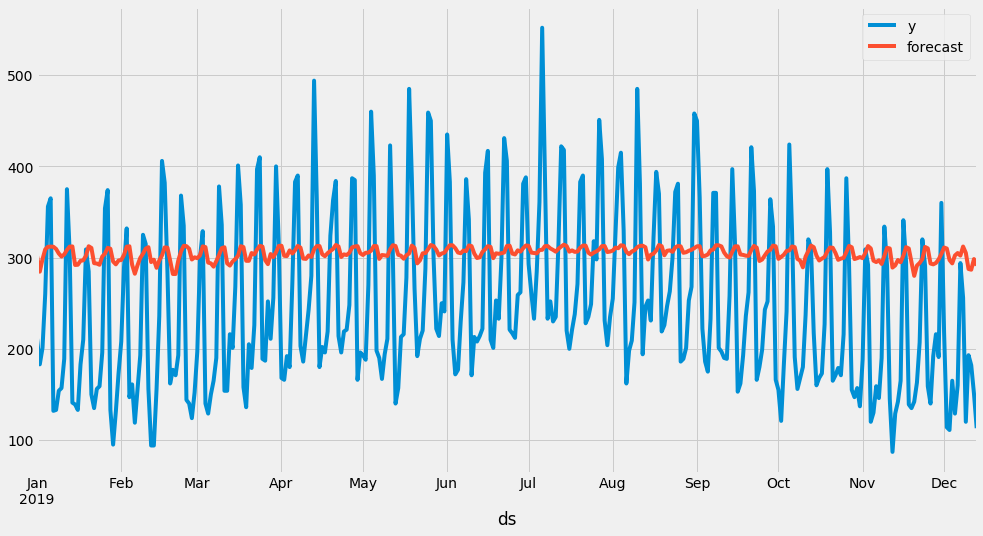

In [25]:
s2s_forecast = model_forecast(s2s_model, pd.concat([d_train[-window_size:],d_test[:-1]]).y.values[..., np.newaxis], window_size)[:, 0]
fcast = pd.DataFrame(s2s_forecast, \
            index=d_test.index,
            columns=['forecast'])

fig, ax = plt.subplots()
d_test.plot(ax=ax)
fcast.plot(ax=ax)
plt.legend()
plt.show()

In [26]:
rmse_test = math.sqrt(mean_squared_error(d_test, fcast))
print("The root mean squared error is {}.".format(rmse_test))

The root mean squared error is 106.8027916382816.


In [27]:
mape = np.mean(np.abs(d_test.y.values - fcast.forecast.values) / d_test.y.values) * 100
print("The mean average percentage error is {}.".format(mape))

The mean average percentage error is 49.98452134227121.
